In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
import numpy as np
import gym
import matplotlib.pyplot as plt
from tools import Agent, plot_values_lake, policy_improvement, discount_cumsum
sns.set_style("darkgrid")

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
env = gym.make('LunarLander-v2')

# deep Q-learning

When the state spaces is continous. It is necessary to have a function for the Q value. A common way to represent and update this function, it is to use parametric function (as neural network).
In other words, we are looking for $\theta \in \mathbb{R}^d$ such as 
$\forall s Q_\theta(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$. We follow the same idea as q-learning:
we eant to update $Q_\theta(S_t,A_t)$ using the target $R_{t+1}+\gamma \max_a Q(S_{t+1},a)$. A natural loss is the mean square error:

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y_t - Q(s,a,\theta))^2]$



$y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$

We have 2 ways to write our function:
1. $Q_\theta : S\times A \rightarrow \mathbb{R}$

in this case greedy policy looks like $\pi(.|s) = \arg\max([Q_\theta(s,a_0), Q_\theta(s,a_1),... Q_\theta(s,a_{dim(A)}]) $

The target is $y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$
2. $Q_\theta : S \rightarrow \mathbb{R}^{dim(A)}$

in this case greedy policy looks like $\pi(.|s) = \arg\max(Q_\theta(s))$

The target is $y_i = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$ for i corresponding to the played action, $Q_\theta(s_t)_i$ otherwise.

In [33]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass 

In [72]:
class DeepQAgent(DeepAgent):
    def __init__(self, env, eps = 0.01, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        self.model.summary()
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_action = Input(name='input_action', shape=(self.env.action_space.n,), dtype='float32')
        xs = Dense(32, activation='relu')(input_state)
        xa = Dense(32, activation='relu')(input_action)
        x = concatenate([xs, xa])
        x = Dense(8, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=[input_state,input_action], outputs=x)
        model.compile(loss='mse')
        return model
    
    def save_model(self, path):
        self.model.save(path)
    
    def act(self, state):
        
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        X_current_state = [np.tile(state, (self.env.action_space.n, 1)), np.eye(self.env.action_space.n)]
        predicted_Qs = self.model.predict(X_current_state)
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        #_ = np.zeros(self.state_shape)
        #_[next_state] = 1
        #next_state = _
        X_next = [np.tile(next_state, (self.env.action_space.n, 1)), np.eye(self.env.action_space.n)]
        predicted_Q_nexts = self.model.predict(X_next)
        if done is True:
            target = reward
        else:
            target = reward + self.gamma * np.max(predicted_Q_nexts)
        target = np.array([target]).reshape(1,-1)
        one_hot_action = np.zeros(self.env.action_space.n)
        one_hot_action[action] = 1
        X_current_state_action = [current_state.reshape(1,-1), one_hot_action.reshape(1,-1)]
        self.model.fit(X_current_state_action, target, batch_size=1, verbose=0, shuffle=False)

In [73]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done)
            rews.append(reward)
        rewards[i] = sum(rews)
    return rewards

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_state (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_action (InputLayer)       [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 32)           288         input_state[0][0]                
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 32)           160         input_action[0][0]               
___________________________________________________________________________________________

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

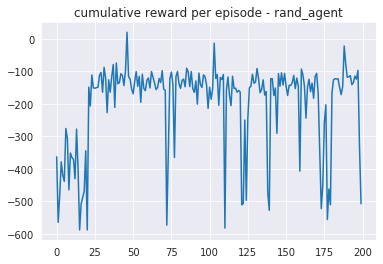

In [74]:
q_agent = DeepQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 200)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [83]:
class DeepQAgentV2(DeepAgent):
    def __init__(self, env, eps = 0.01, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        self.model.summary()
        
        self.predicted_Qs = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(8, activation='relu')(x)
        x = Dense(self.action_dim, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse')
        return model
    
    def save_model(self, path):
        self.model.save(path)
    
    def act(self, state):
        self.predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        action = np.argmax(self.predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        predicted_Q_nexts = self.model.predict(next_state.reshape(1, -1))[0]
        target = self.predicted_Qs
        if done is True:
            target[:] = reward
        else:
            target[action] = reward + self.gamma * np.max(predicted_Q_nexts)
        self.model.fit(current_state.reshape(1, -1), target.reshape(1, -1), batch_size=1, verbose=0, shuffle=False)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
dense_55 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 36        
Total params: 588
Trainable params: 588
Non-trainable params: 0
_________________________________________________________________
[0.03518403 0.10346533 0.23053452 0.04806706]
[0.01107946 0.10955966 0.19471668 0.05101031]
[-0.009014    0.1168847   0.1674694   0.05354151]
[-0.02398183  0.12027498  0.14401774  0.05474363]
[-0.04225441  0.12654302  0.11563     0.05470109]
[-0.049228    0.

[-0.16702588 -0.22952586 -0.08973177 -0.09350751]
[-0.15675944 -0.22083363 -0.09042355 -0.09273315]
[-0.152374   -0.21577534 -0.09705538 -0.09827086]
[-0.1505355  -0.2161212  -0.10526242 -0.1047424 ]
[-0.14403225 -0.22529933 -0.0984204  -0.11276934]
[-0.14660579 -0.22177893 -0.11156704 -0.11912245]
[-0.15551229 -0.22477108 -0.12870511 -0.13045408]
[-0.17234439 -0.23733208 -0.14827994 -0.14702033]
[-0.18228886 -0.24885139 -0.1526022  -0.1555967 ]
[-0.19720894 -0.25929156 -0.17122397 -0.17076573]
[-0.21137121 -0.27461776 -0.17909297 -0.18305287]
[-0.21838516 -0.2727976  -0.19981739 -0.1948797 ]
[-0.23624529 -0.29083985 -0.21178651 -0.21091628]
[-0.2585252  -0.3110392  -0.2300153  -0.23920964]
[-0.27980536 -0.31934264 -0.26730412 -0.26487428]
[-0.29239514 -0.32676655 -0.28196913 -0.3304066 ]
[-0.31964648 -0.34330127 -0.31926036 -0.37209025]
[-0.35656187 -0.37095353 -0.3610714  -0.42305648]
[-0.38968533 -0.4001299  -0.3822985  -0.46083602]
[-0.42846864 -0.43160155 -0.42241317 -0.5092684 ]


Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

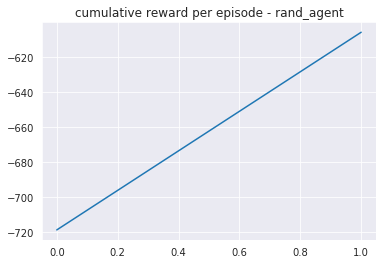

In [84]:
q_agent = DeepQAgentV2(env)
rewards = run_experiment_episode_train(env, q_agent, 200)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [3]:
model = load_model('../src/models/test')

#TODO experience replay